# Real Estate Investment Opportunity Identification

In [217]:
#ADD AN OUTLINE OF NOTEBOOK HERE!

In [218]:
#We start with importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [219]:
import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys

import cv2 #to read images
import glob #to tell it what kind of files to read within the filepath, in this case .jpg's
import skvideo.io


In [220]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from tensorflow.keras.utils import to_categorical #np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [221]:
from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance

import math

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

from skimage.transform import resize   #for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips

## 1. Data Wrangling

Since the tool we are making is designed work from images ALONE, the wrangling phase is to get the images into the right format.
##############################

In [222]:
# Establish the path to read all of the images 

#Will use about 75/25 split for training/testing. Ahmed/Moustafa did 80/20

#Training
path_training_flip   = glob.glob('Houses Dataset/Training Set/Flip_Mixed_Training/Flip_Kitchen_Training/*.jpg') #lolll note - i spaced this group of 4 out so that parts nicely lined up, BUT IT'S *'SPACE'* SENSITIVE!!!!! SO DIDN'T READ/WAS THE WRONG PATH!!!
path_training_noflip = glob.glob('Houses Dataset/Training Set/Dont Flip_Mixed_Training/Dont Flip_Kitchen_Training/*.jpg')

#lol wow so that last slash at the very end actually DOES matter!! it didn't work without it - was getting 'empty set' error
#but it won't tell you that here for some reason

#Testing
path_testing_flip   = glob.glob('Houses Dataset/Testing Set/Flip_Mixed_Testing/Flip_Kitchen_Testing/*.jpg')
path_testing_noflip = glob.glob('Houses Dataset/Testing Set/Dont Flip_Mixed_Testing/Dont Flip_Kitchen_Testing/*.jpg')

#glob looks for all files/filepaths that follow/contain a specified pattern, using the *wild card, so here *.jpg!

In [223]:
#sA innocent beginnings!:
#so just thought of something - the point for testing is IT'S supposed to tell us whether it thinks it should be a flip/
#not flip... so i was like then why are WE giving it the answer right off the bat!? but the thing is it doesn't realize
#we're telling it the answer. we're only doing this for our OWN purposes for organization to make it easy for ourselves/
#to see/compare ITS answers to the RIGHT answers!
#wait actually so... how does it work to tell you the 'accuracy' of the prediction at the end?
#like cuz you label the flip/not flip. so like is it just taking those images and tryna slap a label on and then
#comparing to your label? how does it not cheat/get bias? how does it do this?

## 2. Data Preprocessing

Overall Procedure:
    -Generate the training & test images sets, each having a separate one for sell/not sell
    -Make list of labels for the images
    -Combine the training images; Combine the testing images; And same for labels
    -Combine the training images with their labels; Same for testing
    -Shuffle each
    -Separate the labels from the images in each

That will get us Xtest,Xtrain,ytest,ytrain and so are ready for modeling & prediction!

In [224]:
# Define a function that'll get each image ready for modeling / preprocess

def image_preprocessing(path):
    #so with this function we'll give it the filepath. in fact, amazingly, this is the ONLY argument required!!
    
    #empty list to store all finished, preprocessed images
    images = []

    #loop through all the path images, preprocessing each one
    #remember the path uses GLOB so it's only getting .jpg's in our case since that's what we defined/wildcarded.
    #there should only be .jpg's in there anyway, but just in case! oh like there may be FOLDERS in there, but like i'd think it'd automatically pass OVER those anyway?? like wouldn't even 'SEE'/be presented?
    ##################################################
    for i in path:
        #read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will be the same size
        img = cv2.resize(img, dsize = (32,32), interpolation=cv2.INTER_CUBIC) #changed from raghu's 70, 140
        #interpolation tells it how to "create new pixels" to make the image look smoother as you make it bigger, aka *FILL-IN* the gaps!!!
        #rather than just stretch the original pixels and risking "pixely" images
        #bicubic is the smoothest cuz it's curved/polynomial

        # Crop to remove excess of the images we don't need for modeling, like around the border/near the edges, unnecessary noise,
        #watermarks, text etc
        
        #okay so we just set the pic above to be 32 pixel width x 32 height
        #so now we're cropping it to be MIDDLE 28 x 28! basically, it starts @ pixel 2, in each dimension, then goes 28, to pixel 30!

        #y,x are the STARTING pixel location height, width address/coords
        #to START trim at / KEEP picture at, then h,w is THE ACTUAL DESIRED LENGTH OF THE PICTURE!!!
        #img = img[y:y+h, x:x+w] (#so if you're okay with STARTING AT 0, then ofc would just be img[y:h, x:w]!)
        #so we ofc keep the option open bc prob in MOST cases we wouldn't be starting at 0!/the edge!
        #so like this is setting the pixels we wanna KEEP! so let's say you've got 100x100 pixels, and you wanted to trim centered/evenly,
        #so that you take 20 pixels off the top and 20 pixels off each side - top,bottom,left, right; aka the *MIDDLE 60*!!!
        #so like you'd want pixels 20 thru *80*! thus, it'd be: img = img[20:60+20,...] aka 20:80!!!
        #so since/if (0,0) is top left, then this example of 0,100,0,70 will keep only TOP 100 pixels of 140 and
        #chop off BOTTOM 40!! but he's okay w/ keeping ALL the width
        
        #the way they do it is starting pixel & number of pixels to go from there, aka the DESIRED PIXEL LENGTH!
        #SO THE y & x ARE THE *STARTING* y,x pixel point you wanna begin crop at/start keeping at!!!
        #then of course the h & w are actual height and width in pixels, so to get the right crop you gotta treat like
        #this,- algebraically/addressly/plotly, so that, say you want the new cropped pic to be only the MIDDLE 100
        #vertical pixels in heighth, out of 140 original, then you gotta START AT 20, then "ADD" 100 to represent the
        #desired image size, which'll take it to 120,-> THE DESIRED END LENGTH PIXEL LOCATION/ADDRESS!!!
        #but wonder why he didn't opt for the MIDDLE, and didn't crop WIDTH at all...
        
        #crop down to the middle 28x28 pixels (pixels 2:30!)
        y,h,x,w = 2,28,2,28
        img = img[y:y+h, x:x+w]
        

        # Adjust brightness, contrast
        alpha=1.5 #contrast/gain...wait, but then somewhere else it says *WEIGHT* of first image??
        beta=0.5  #brightness/bias..and this says elswhere weight of SECOND image!?!
        #gamma=??
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        #addWeighted helps to blend/transition the two images together, by specifiying respective weights / alpha, beta and gamma values, like how visible
        #or transparent one is
        ##################################################
        #.....BUT WE ONLY HAVE *ONE* IMAGE!?!?! SO WHAT IS IT BLENDING?!?
        #is it like where converting the image to a blend of itself (in this stage of the preprocess(ing) process (lol) and like a plain WHITE/BLANK
        #image or something?!?!)
        ##################################################
        #theory
        #the np.zeros thing is the 2nd image?? it's creating an image of 0 size and 0 dtype? what's 0 dtype?
        #is this just a way of creating a 'blank' image??
        #then what is 0?? the template is:
        #cv.addWeighted(image1, alpha, image2, beta, gamma[, dst[, dtype]]) #note this is cv and not cv2... any difference???
        #this is confusing cuz the *0* is in the BETA spot and BETA is in the GAMMA spot! mistake??
        #also more confusing cuz alpha & beta here are the respective WEIGHTS to give to each image
        #whereas above it had to do w/ contrast & brightness?
        #and also, it seems like for image2 we're creating a 'blank' image, which we're further giving 0 weight...
        #which poses the question - why even bother doing a blend if we're not blending?? we're only using the first
        #image by itself! well maybe we're blending an image with a blank image to attempt to create a picture with a
        #'transparent' background, like those png images! to remove any excess / nonessential background noise around the
        #main part / meat of the picture?
        #but also, shouldn't alpha & beta be on a scale of 0 to 1 and sum to 1?? Or actually, I guess you could look at
        #it as each one can be an independent percentage transparency of its full resolution, so they can both be 1
        #for example and so don't necess have to add up to 1... BUT they DO both still need to be some RATIO / can't
        #be more than 1! but alpha is 1.5??
        
        
        
        # Normalize the images to be black and white inversing images(??) and then dividing by 255 cuz that's the highest count for pixels
        #in RGB format corresponding to *BLACK* if EACH of R,G&B are 255! so i'm guessing this is converting to grayscale?? by making each dimension (RGB?)
        #of each pixel a *PERCENTAGE OF BLACK*!!!!! aka that's what grayscale is!!! 0=white,1=black! 0/255,255/255!!!
        #but yeah not clear on what 'bitwise' does, maybe just goes thru each pixel/bit, but seems that '_NOT' is an operator you can add on
        #to do like the arithmetic/RGB INVERSE....
        #so we START by inverting the colors... which i guess for some reason makes it easier to then convert to grayscale by dividing by 255??
        #WHY CAN'T WE JUST JUMP STRAIGHT TO THAT *DIRECTLY*!!! without inverting!!!
        ####################################################################################################
        
        #initially i THOUGHT we wouldn't wanna make grayscale:
        #this would be an important step in applications where color is irrelevant and it's just noise and you wanna focus
        #on the features. but in our application, REAL ESTATE, color is definitely very important. like if the floors are
        #modern gray, that property will def have more value
        #but Raghu said no we ALWAYS wanna grayscale - YOU as human can't see the 'color' but the computer can tell EXACTLY WHAT color it is!!!
        
        img = cv2.bitwise_not(img)  #can look up this function later
        img = img/255               #TO REDUCE ALL THE RGB PIXEL COLOR VALUES TO BETWEEN 0 & 1!!! CUZ THE COLOR RATING/VALUE RANGE IS FROM 0 TO 255!!!
        #ORIGINALLY I THOUGHT THIS WAS DIVIDING BY 255 TO GET EVERYTHING IN GRAYSCALE LOL SO I COMMENTED OUT!!

        #OHHHHHH! so the dividing by 255 *ISN'T* converting colorscheme to grayscale but rather to simply simplify the RGB numbers of each pixel to something
        #easier to interpret? b/w 0/1!

        # Append the img to the list images
        images.append(img)

    # Return the list with the preprocessed images
    return images

#okay so overall, this is iterating thru our images in our path folder and reshaping/resizing/recoloring them and
#tryna crop out the background noise as much as possible?

In [225]:
# Read and preprocess the training data

#these are the X's

img_training_flip = image_preprocessing(path_training_flip)[:12]

img_training_noflip = image_preprocessing(path_training_noflip)

img_testing_flip = image_preprocessing(path_testing_flip)[:5]

img_testing_noflip = image_preprocessing(path_testing_noflip)

In [226]:
len(img_training_flip),len(img_training_noflip),len(img_testing_flip),len(img_testing_noflip)


(12, 12, 5, 5)

In [227]:
#these are right/match what are in the folders!

In [228]:
# Set the labels

#initial cute realization mA!:
#ohhh, wait, think i got it. so we wanna train this thing to know when to flip and when not to flip, so "DO flip"
#is 1, aka TRUE!!! and don't is 0, seen below
#so we're assigning a value of 1/True for EVERY item in the one's we wanna flip, training & test; and same for not flip

#for the TEST we're programming the ANSWER KEY!

#im a little confused on doing it for the testing set tho? why are we assigning its values? isn't the point that we're
#supposed to SEE how well it does, like it SHOULD result in 1's for flips and 0's for nonflips...
#so maybe it's just gonna use these as benchmarks of what they SHOULD/'VE BEEN so we can see how the
#actuals compare to these shoulds/ideals/theoreticals

#'y' is always used for the predictor variable! X for FEATURES!/independent variables using to predict!
#the images themselves are the X's, but we didn't label their variables w/ X
y_train_flip = [1 for i in range(0, len(img_training_flip))]

y_train_noflip = [0 for i in range(0, len(img_training_noflip))]

y_test_flip = [1 for i in range(0, len(img_testing_flip))]

y_test_noflip = [0 for i in range(0, len(img_testing_noflip))]

## 3. Modeling

In [229]:
# Define the X_train, X_test, y_train and y_test for analysis

#hmm okay, so the X's are the images themselves!!
#and the y's are what we just saw above - 1/0 LABELS!
#and as we see, combine/unsegregate the flips/notflips into one! cuz together they still make up the training/testing sets

##################################################################################################
#Note the difference b/w concat & append! concat defaults to stacking VERTICALLY -> axis = 0
#and append defaults to FLATTENING COMPLETELY -> fully unraveling / stretching / connecting / daisy-chaining
#ALL rows out to ONE SINGLE LONG ROW!!!

#can do any kind of 3 stackings w/ either, but best to go w/ one who has what you're looking for as the default
#so that's why we use concat for X, cuz we want those vertically stacked,
#whereas we want our y's as one single long row
#... wait WHY THO????
#so for the X's, the flips & non-flips images will be two separate rows
#for the y's, the flips & non-flips VALUES will be ONE SINGLE ROW!
#question is - which direction are img_ & train_flip orientated?? which way does append naturally stack?
#okay, so i did a basic append using an empty list, which is what it seems they did w/ image_processing, and it
#APPENDS SIDEWAYS!!! horizontal/across/left-to-right. so then our hunch was right - concatting 2 X lists of images - those
#lists are each sideways (as opposed to upright; they're 'supine' lol), so when we concat w/ axis=0, they'll be stacked
#vertically, rowswise, so yes, each of these new X vars will be 2 rows, one flip one nonflip
#okay and then checked for y's by doing a practice list comprehension and that ALSO created a sideways/-wise list!
#thus, appending two y lists on axis None will make one longe list/row!!! and actually, didn't even need to practice
#check cuz anytime doing axis None for either (concat or append), it'll first AUTOMATICALLY FLATTEN the composite
#lists regardless of orientation! so that way it can just daisy-chain them together!
#so not sure if there's a reason *WHY* both are oriented horizontal, but maybe that's the key point - maybe it's not
#that they have to be oriented one way or the other, as long as they're oriented the SAME direction!


#X's/features are two rows
X_train = np.concatenate((img_training_flip, img_training_noflip)) #default axis is already 0!!!

X_test = np.concatenate((img_testing_flip, img_testing_noflip))

#y's are one long row
y_train = np.append(y_train_flip, y_train_noflip)#default axis = None)

y_test = np.append(y_test_flip, y_test_noflip)

In [230]:
X_train

array([[[[0.7254902 , 0.56862745, 0.34901961],
         [0.61568627, 0.45490196, 0.25490196],
         [0.74509804, 0.54509804, 0.29019608],
         ...,
         [0.76862745, 0.63137255, 0.4745098 ],
         [0.80392157, 0.6745098 , 0.4627451 ],
         [0.40392157, 0.25098039, 0.03921569]],

        [[0.59607843, 0.43137255, 0.23137255],
         [0.82745098, 0.67843137, 0.4745098 ],
         [0.66666667, 0.53333333, 0.34509804],
         ...,
         [0.61960784, 0.41568627, 0.18039216],
         [0.78431373, 0.63137255, 0.35686275],
         [0.34117647, 0.20784314, 0.        ]],

        [[0.44313725, 0.2745098 , 0.09019608],
         [0.6745098 , 0.49019608, 0.24313725],
         [0.81568627, 0.70196078, 0.45098039],
         ...,
         [0.50196078, 0.33333333, 0.10196078],
         [0.71372549, 0.58039216, 0.28627451],
         [0.64705882, 0.4745098 , 0.20784314]],

        ...,

        [[0.8627451 , 0.71372549, 0.49803922],
         [0.83137255, 0.70980392, 0.48627451]

In [231]:
img_training_flip

[array([[[0.7254902 , 0.56862745, 0.34901961],
         [0.61568627, 0.45490196, 0.25490196],
         [0.74509804, 0.54509804, 0.29019608],
         ...,
         [0.76862745, 0.63137255, 0.4745098 ],
         [0.80392157, 0.6745098 , 0.4627451 ],
         [0.40392157, 0.25098039, 0.03921569]],
 
        [[0.59607843, 0.43137255, 0.23137255],
         [0.82745098, 0.67843137, 0.4745098 ],
         [0.66666667, 0.53333333, 0.34509804],
         ...,
         [0.61960784, 0.41568627, 0.18039216],
         [0.78431373, 0.63137255, 0.35686275],
         [0.34117647, 0.20784314, 0.        ]],
 
        [[0.44313725, 0.2745098 , 0.09019608],
         [0.6745098 , 0.49019608, 0.24313725],
         [0.81568627, 0.70196078, 0.45098039],
         ...,
         [0.50196078, 0.33333333, 0.10196078],
         [0.71372549, 0.58039216, 0.28627451],
         [0.64705882, 0.4745098 , 0.20784314]],
 
        ...,
 
        [[0.8627451 , 0.71372549, 0.49803922],
         [0.83137255, 0.70980392, 0.48627

In [232]:
#commented out to avoid stoppage / breakage when running whole notebook!
# img_training_flip.shape
# >> output:
# ---------------------------------------------------------------------------
# AttributeError                            Traceback (most recent call last)
# /var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_90203/1074584411.py in <module>
# ----> 1 img_training_flip.shape

# AttributeError: 'list' object has no attribute 'shape'

In [233]:
# hain? why is this being treated like a list when it looks exactly like X_train??

In [234]:
y_test

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [235]:
#btw - THIS IS GOOD TO SEE THAT THERE'S COMPLETE SEGREGATION AT THIS POINT BECAUSE THIS SHOWS THE APPENDED*
#/*COMBINED* FLIP/NOT FLIP SET THAT MAKES UP/COMPRISES Y_TEST!!!!!
#later we're gonna SHUFFLE IT UP!

In [236]:
# Check if shapes make sense and match requirements

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24, 28, 28, 3)
(24,)
(10, 28, 28, 3)
(10,)


In [237]:
#so the images themselves, aka Xtrain/Xtest, are 133 images, with 28x28 pixels, each pixel having 3 features -> RGB! so it's *4-DIMENSIONAL*, AS WE SEE!

#vs. y's, as expected, are simply *ONE-DIMENSIONAL*, AS WE SEE!/and as EXPECTED, cuz it's simply a LIST OF NUMBERS!!!!

In [238]:
#double brackets
np.shape([[(1, 2), (3, 4), (5, 6)]])

(1, 3, 2)

In [239]:
#single brackets
np.shape([(1, 2), (3, 4), (5, 6)])

(3, 2)

In [240]:
#EQUIVALENT TO USE BRACKETS INSTEAD OF PARENTHS INSIDE!
#single brackets, but each element has brackets
np.shape([[1, 2], [3, 4], [5, 6]])

(3, 2)

In [241]:
#*****NOTE!!!!!! YOU CAN'T JUST HAVE A SET OF LISTS WITH *NO* SURROUNDING
#BRACKETS!!!!! ALWAYS MUST BE OVERALL ENCAPSULATED BY A PAIR OF OUTERMOST
#BRACKETS!!!!! #CLOSURE!!!
#here's what happens WITHOUT surrounding/outermost brackets!
#so if you ALREADY HAVE your outermost pair of brackets,
#and you add ANOTHER, like we did, which in this/that simple example
#case we didn't really need cuz was no OTHER element in that level to separate
#that set from, but still, it'll prep it for that/give it an add'l
#level!!!!!
#NO brackets

#commented out to avoid stoppage / breakage when running whole notebook!

# np.shape([1, 2], [3, 4], [5, 6])
# output >>

# ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# /var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_90203/2602814256.py in <module>
#       1 #EQUIVALENT TO USE BRACKETS INSTEAD OF PARENTHS INSIDE!
#       2 #double brackets
# ----> 3 np.shape( [1, 2], [3, 4], [5, 6] )

# <__array_function__ internals> in shape(*args, **kwargs)

# TypeError: _shape_dispatcher() takes 1 positional argument but 3 were given

In [242]:
#always gotta have an OUTER/WRAPPER pair/set of brackets

In [243]:
#like for np.shape([1, 3]) >> (2,), cuz just one dimensional array, like LIST basically!
#but w/ DOUBLE brackets: np.shape([[1, 3]]) >> it goes to (1, 2) bc there's one 'row' with 2 columns!!!!!

#likewise:
#single:
    ##np.shape([(1, 2), (3, 4), (5, 6)]) >> (3,2)
        ###3 items, 2 sub-items each
#double:
    ##np.shape([[(1, 2), (3, 4), (5, 6)]]) >> (1,3,2)
        ###OHHHHHH! so basically, adding another pair of outer brackets SEPARATES THIS SECTION OFF AND MAKES IT INTO ANOTHER *LEVEL*!!!!/*LAYER*!!!!
        #so that surrounding pair of brackets makes it like ONE of these sets, and then the rest explains the internal/what we already saw/knew
###################################################################################################################################################
#so each set of wrapping brackets is a layer, aka a DIMENSION, aka another/an additional member of the .shape output! aka 4 items/numbers
#means 4 dimensions; but then for the INNER MOST sub-layer that's present in every NEXT-TO-inner-most sub layer gets - for that portion of the whole
#.shape set of numbers - just ONE number if it's a LIST/1-DIMENSIONAL, just set of straight NUMBERS!!!! MAKES SENSE!!!! IT'S A 1D LIST!!!!
#or, if it's a LIST OF *LISTS*, THAT'S *TWO* DIMENSIONAL!!!!! so it'll have 2 numbers/dimensions associated with that: (#items, #sub-items-per-item)!!!!!!
#so the FINAL number in the shape will always ofc be the SMALLEST UNIT/BUILDING BLOCK!!!! and second-to last will be the second-to-last layer/second-most-
#innest (;P) layer!!!!!

#so working our way from the inside OUT!
    #using TRAINING set as example
    #each PIXEL of each image has 3 numbers, for each of RGB!
    #there are 28 x 28 PIXELS per image! so for each of height & width, there are 28 sets of 3!
    #and there are 133 *IMAGES* so each of 133 pictures has a 28x28 set of elements, and within each of
        #those elements is 3 sub-elements!!!!!
    

#remem the machine interprets/transcribes/encodes images as numerical data structures / A SET OF PIXELS W/ COLOR VALUES!


#we divided by 255 earlier to convert each pixel's color component value to scale b/w 0 & 1!

#when you have more than 2 dimensions, it's kinda like you STILL have rows and columns, but then you got like SUB-values, cuz of
#like *"MERGED"* cells!
#4 sets of brackets which may be why there's 4 elements in the shape/4 dimensions!
#OKAY ALHAMDULILLAH ALLAH GAVE ME THE ANSWER!!!:
#you can understand more clearly what's going on when you DON'T have the same height/width pixels! so using original template numbers:
#each pixel is described by 3 color values, so there's 70 sets [brackets] of 3 elements (together representing ONE "ROW" of pixels,
# aka across the width of 70 pixels), and then since there's *100* "ROWS" of 70 pixels each, for the 100-pixel-HEIGHT, making for 100x70 image pixels!
#so that's 100 rows of those 70x3 sets of pixels going down (height pixels) -> which makes up the complete image!!!!!!

In [244]:
# Now combine the images & labels TOGETHER! so that we can SHUFFLE THEM while still keeping the correct labels INTACT! unseparated!
# we'll have to do this SEPARATELY of course for both training & testing, cuz of leakage/peekage! ("pack"age;P)

#training

X_train_shuffle = []

#enumerate() will create a list of tuple pairs: each image +/w its index position!
    #so i=index of that image, j=image at that index! great couple/tuple pair!
for i,j in enumerate(X_train):
    # This will pair the training image itself with its truth LABEL (y)
    new_array = (j, y_train[i])
    #populate the list with these labeled images, which we will next shuffle!
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)
#hmmmmm - why do we need to make it an np.array()? so this is like an array of arrays? only works in this format?
    
    #Hmm so enumerate prints the element along w/ its index number as a tuple pair
    
    #so enumerate(X_train) will give like [(0, 'img0'), (1, 'img1'), etc...]
    #so the i,j in this refer to the index position and the image, respectively-> (index, image)
    #so, this 'new_array' makes (image, label)
    #then we add each of these into the shuffle_list!
    
    #ahh okay. so y_train is comprised of an array of 1's for/from y_train_flip & an array of 0's from y_train_notflip
    #it's 1d, combined, array of all 1's followed by all 0's - WHICH IS EXACTLY / MAINLY WHY WE WANNA *SHUFFLE* IT!!!!! to not
    #risk training the model / the model learning *FALSE* PATTERNS!!!! COINKIDINKS!

    #ofc the images THEMSELVES, before shuffling, are also segregated flip/not flip, in training - so same idea - don't want false attribution
    #don't want model/trainer/train*ee* to pay attention to wrong things!get confused!

    ###################
    #NOTE! we don't have to worry about shuffling the TEST set, cuz THAT DOESN'T MATTER!!!!
    #LOL!!! CUZ UNLIKE A HUMAN, A COMPUTER WON'T GET INFLUENCED BY THE *ORDER OF THE TEST QUESTIONS*!!!!! ITS PERFORMANCE WON'T CHANGE!!!!!
    #LOL not like us where we're like, get distraught like - WAIT THERE CAN'T BE 3 '1's IN A ROW!!!!! LOL - FOR MACHINE LEARNING THERE MIGHT BE
    # *3*MILLION* 1's in a row!!!!!

    
    #so what was the point of enumerating & getting the INDEX number if we didn't even use it?? only used the *j*!

    #so new_array = (j, y_train[i]) pairs them off by taking j image sequentially from X_train and pairs it off w/
    #the sequential value from/in y_train, which is lined up so it corresponds to it! so like [('img0', 1), ('img1', 1), etc...]
    #did we need to do that though?
    #couldn't we have just directly done:
    #for i,j X_train, y_train: 
        #new_array = (X_train[i], y_train[j])???
    #or even just concatted the 2 tables together?!?!? like if were dataframe, just gotta *TACK ON* the y_train to the X_train,
    #and same for/in tests, and that way we'd still preserve/abide by separation/parda rule!leakage!securitybreach!
    
 
    #we want them as inseparable/interlocked PAIRS cuz we're gonna SHUFFLE THEM SO NEED THEM
    #TO STAY INTACT!!!!
    #can't do that w/ simple rows/columns/df format. this is more secure. cuz tuples are IMMUTABLE!!!
        #^hain??
    ###############################################################################################
    #but couldn't we spit out tuples directly w/ /create tuple pairs using ZIP, like simply:
    #new = zip(X_train, y_train) --> so - this WOULD work if we were dealing with LISTS but NOT arrays! if you try this
    #w/ arrays, it'll simply make ONE SINGLE TUPLE out of the WHOLE first array and WHOLE second array!
    #i tried doing using a for loop but didn't work either:
    #for x, y in keys, values:
        #zip(keys[x], values[y])
        #error: 'not enough values to unpack (expected 2, got 1)'...
        #tried as/w inner loop/loop-w/in-loop, but that errored too
        #also tried as lists instead of arrays, but that said 'TOO many values to unpack'! lol - but this'd be an
        #unnecessarily long way to do it anyway for lists. if you got lists you got it easy!
    

    #however, these 2 things probably COULD have been set up as lists instead of arrays?

    #BUT - i'm guessing there was probably a reason to set up as arrays, like maybe many of the other functions could
    #only be done if np.arrays, like shuffling

    #also, instead of appending new_array to X_train_shuffle,...we could've skipped the helper variable/middle man and appended directly to X_train_shuffle

    #note. so initially the 'i' refers to the INDEX num of X_train, cuz that's the part of enumerate
    #but then we're calling y_train[i]. iteration runs the same number/order as indexes, so that works

    #hmmm, even when i tried to replicate this and do a for-loop w/ enumerate w/ arrays, it still acted the same as simply doing zip!!!
    #so i wonder-- is that what we're actually going for? or, does it just LOOK like this output/display but in actuality
    #it is tupled the way we want? i.e. in effect/practice, the elements are PAIRED-WEDDED-BONDED the way we want???


#coulda shuffled here!
#np.random.shuffle(X_train_shuffle)


In [245]:
#Note, we call it 'X'_test_shuffle & X_train_shuffle, but it's got X+AND+y now...
#so why we doing that?
###*CUZ WE'RE GONNA GO *RIGHT BACK* AND *SEPARATE AGAIN* RIGHT AFTER WE SHUFFLE!!!!!!

In [246]:
#line up the test images with their labels / add the labels on/to the test images

X_test_shuffle = []

for i,j in enumerate(X_test):
    new_array = (j, y_test[i])
    X_test_shuffle.append(new_array)
    
X_test_shuffle = np.array(X_test_shuffle)

#coulda shuffled here:
#np.random.shuffle(X_test_shuffle)

#BUT DO WE EVEN NEED TO SHUFFLE THE TEST SET?!?!
############################################################

In [247]:
#shuffle both the train & test sets

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)

#NOTE!!!!! YOU DON'T HAVE TO DO ANYTHING TO *SAVE* THE SHUFFLING ORDER!!!
#in fact, if you save this to a variable, i think when you display that variable, it'll just EXECUTE this code!!!
#like it's just a *set of instructions/COMMAND!*

In [248]:
#Now that test & train are each shuffled, separate the y labels back off from each of them since model training/testing/predicting requires
#separation of X & y!

#but i guess since this isn't a dataframe, and maybe *can't* be a dataframe? it's not easy to separate...
#unlesss,... IF WE MADE *EACH* OF RGB ITS OWN COLUMN!!!!!!

#but, otherwise - this what we'll have to do:

#we already have these arrays w/ these names, but remem they contained ONLY X/y, respectively, and obviously weren't SHUFFLED at the time!
#so we're just gonna replace/overwrite these w/ synchronized-shuffled pairs independently!
X_train = []
y_train = []

#loop thru the combined/lined up training set, and send the image to X_train and the label to y_train!!!!
for i in X_train_shuffle:  #remem, X_train_shuffle is a set of shuffled up PAIRS of images w/ their corresponding values
                           #so that's the great thing - we don't risk mixing up the data since we're shuffling PAIRS!!! keeping them intact
    
    #so each 'i' is a tuple pair of (image, value)
    # The array containing the picture would be the one that is in the index 0
    image = i[0] #ohh okay, so this is referencing the 0-index of EACH i-element-tuple-pair within X_train_shuffle,
    #which is the IMAGE!! cuz i([[0],[1]]) = X_train_shuffle([[0],[1]]) = X_train_shuffle([[image],[value]])!!!
    # The label would be the array that is on the index 1
    label = i[1] #and so the 1-index-position of each tuple-pair-element in X_train_shuffle is the value!!!
    # Append the values and the labels to separate arrays

    #REALLY WE COULD *SKIP* THE ABOVE/HELPER AND JUST GO *DIRECTLY* TO THE APPEND, ONCE AGAIN?!
    X_train.append(image)
    y_train.append(label)

#so it's just peeling apart / separating out the pair into it's parts! and putting into the respective bucket/bins/indep lists!
#: 1st element / value / X / image into the X list and 2nd element / label / y / classifier to the y list!

#hmmm okay, so now we store ALL the X_train images in one list(? or array?), SHUFFLED
#oh - check below - again, not shure why didn't make arrays directly up here but yeah, these above as they stand are LISTS!
#and do the same for the y-values
#BUT REMEMBER! they were shuffled TOGETHER! as PAIRS! so these will STILL line up if we wanna join em back together!
#and if they're lists we can even re-tuple/combine them now easily!


#but again - question is - why do we wanna separate em into diff lists? i get it tho that if this is something we wanted
#to do, we couldn't have simply taken these lists independently CUZ THE WHOLE POINT WAS TO TUPLE-PAIR-TIE THEM!!!
    
#but is it necessary to do a for loop to get the 'columns' of this tupled array? hmm doesn't seem so - remem how this
#'tupled' array object looks like? seems to behave how you'd expect off that - nothing you can really do w/ it?

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)

In [249]:
X_test_shuffle

array([[array([[[0.69803922, 0.40392157, 0.08627451],
                [0.77254902, 0.45098039, 0.09803922],
                [0.8627451 , 0.58039216, 0.27843137],
                ...,
                [0.69019608, 0.54901961, 0.25490196],
                [0.51372549, 0.2627451 , 0.        ],
                [0.62352941, 0.28627451, 0.        ]],

               [[0.68627451, 0.38431373, 0.01960784],
                [0.71372549, 0.40392157, 0.0745098 ],
                [0.70980392, 0.44313725, 0.17254902],
                ...,
                [0.79607843, 0.63137255, 0.40784314],
                [0.43137255, 0.16862745, 0.        ],
                [0.5372549 , 0.16862745, 0.        ]],

               [[0.6627451 , 0.40392157, 0.20784314],
                [0.88627451, 0.59215686, 0.28627451],
                [0.90196078, 0.54509804, 0.22745098],
                ...,
                [0.71372549, 0.54509804, 0.31372549],
                [0.34509804, 0.07843137, 0.        ],
               

In [250]:
#hmmm - ... - ahhhh okay - so i guess it's pretty hard to see in this view w/ so many values/pixels but the VERY LAST thing is what i was looking for -
#you see that 0 in the bottom right corner? *THAT MUST BE THE Y-LABEL*!!!!! that's why it's outside alllll the other brackets all on its own/lone/lownsome!!!!!
###########################################################################################################################################################
# but also - WHY ARE THERE SO MANY *ZEROS*?!? well, 0 is white, so...
#could be that this pic has alotta white pixels??
###########################################################################################################################################################
#Also - IS IT SUPPOSED TO BE AN *ARRAY WITHIN AN ARRAY*?!?!

In [251]:
X_test_shuffle.shape

(10, 2)

In [252]:
#ohhhhhhh, interesting....... so we 'converted' these to just *2* dimensions?.... i was thinking since we added on y labels, that we made like a *5th*
#dimension!?! lol, but i guess we simplified it and like 'compressed' it to a 2dimensional shape, even tho you still see the many sets of brackets
#but yeah, i guess now it's SIMPLE! the dimensions represent the 47 test images, and the 2 is....???
###########################################################################################################################################################

In [253]:
X_train_shuffle.shape

(24, 2)

In [254]:
#okay, at least that's what we expected, meaning based on what we just saw w/ test shuffle, aka only the first term is changing and reflects
#the number of samples!

In [255]:
# Same for test

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    image = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(image)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)

In [256]:
# Make sure shapes are the same as their originals
#bc at this point, now that we SEPARATED again, we're BACK TO WHERE WE STARTED in terms of SHAPE/SIZE!!! w/as the originalal X/y train/test!!!
#bc all we did after all/that was essentially SHUFFLE it!!! so these are all the SAME *SET* of data as their original, - didn't alter / edit / add /
#remove any data/points!, - they're just in a different ORDER!!!
#and the great thing is that, even tho they're SEPARATED, they're STILL *LINED UP*!!!!
#lol, like when a severed hand (Allah protect us!!!!) can still move/be controlled by the brain! (is that true?)

#we could've given these new names ofc btw, instead of overwrite, but i guess one approach / preference / advantage is having LESS variables!
#other times/perspective is that's GOOD cuz advantage is keeping things SEPARATE and keeping a TRACK/RECORD / PAPER TRAIL!

#if give new names above so we can differentiate and keep rather than overwrite and compare side by side here!
#but if not, just scroll up or do side-by-side to when we did it last!
#can make nice like put text like: print('The shape of X_train originally was %X_train.shape% and now it is %X_train_shuffled.shape%')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24, 28, 28, 3)
(24,)
(10, 28, 28, 3)
(10,)


In [257]:
# Function for neural networks

def neural_network():  #if it has no args then that's really easy - will just execute code body as is! that means there's no OUTSIDE variables / params it's dependent on!
    model = Sequential()
    #dox: "Sequential groups a linear stack of layers into a tf.keras.Model."
    #"A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor."
    #so i guess for us, that's One Image, One Label??
    ############################################
    #interestingly, Sequential has very very little args, which is prob why we usually see it BLANK like here!
    #and why it seems to be the norm to do what he does below, which is "ADD" THINGS TO IT!!!!
    
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform', input_shape=(28, 28, 3))) #don't remember why, but i tried it with removing kernel initializer to let it default, which apparently is to 'glorot_uniform'?
    #About Conv2D:
#"2D convolution layer (e.g. spatial convolution over images)"
#"This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well."
    
    #32 should be the FILTERS - but not sure what that is... says: "Integer, the dimensionality of the output space (i.e. the number of output filters
        #in the convolution)."
        #SO NOT SURE HOW HE GET 32?!? AND WHAT IT'D BE FOR US?!
        ############################################
    #(3,3) should be 'kernel size', for the 'height/width' of the 2D 'convolution window'....
        #so don't know how to determine what this should be!
        ############################################
    #activation - the activation function to use. don't know what this means.... &don't know what other choices there are. won't use any if don't specify
    ############################################
    #padding: not sure what padding is, but says: " "same" results in padding with zeros evenly to the left/right or up/down of the input."
    #input_shape is just the shape of the images! 28x28 RGB pixels!

    #AND THERE ARE MANY OTHER ARGS JUST FOR THIS!!!!!

    model.add(MaxPooling2D((2, 2)))
    #a little on MaxPooling2D:
    #"Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window
    #(of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension."
    #the (2,2) should be 'pool_size'
    #"integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window.
    #If only one integer is specified, the same window length will be used for both dimensions."
        #lol so we could just write 2 ALONE?! like, not even in parenths?! ;D
        #but yeah - no idea what this means - what's a window/size, what max??
        #WHAT VALUE SHOULD WE DO?!
        ########################################################################

    model.add(Flatten())
    #"Flattens the input. Does not affect the batch size."
    #only arg this has is 'data_format', which defaults to 'channels_last'
    #don't know what this really means
    ########################################################################
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform')) #don't remember why, but i tried it with removing kernel initializer to let it default, which apparently is to 'glorot_uniform'?
    #"Just your regular densely-connected NN layer"
    #"Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as
    #the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer"
    # 128 is the 'units': "Positive integer, dimensionality of the output space." ? -> but SAME THING that *FILTERS* said above!in Conv2D
    #again, no idea what this really means or what these args do and if these vals are appropriate here, or if we needa specify MORE/different ones...
    ########################################################################
    
    model.add(Dense(1, activation='sigmoid'))
    #oh.... so, we meet again? so is it like for every 'dense layer' we want, we just add another line for it separately??
    #why 1? why diff activation??

    #man, this'll be hard to GridSearch! how do you do it when you're working with *ADDS* and not NATIVE ARGS TO THE MODEL THEMSELVES?!?!
    ######################################################################################################################################################

    #optimizer
    opt = SGD(lr=0.001, momentum=.9)
    #"Gradient descent (with momentum) optimizer."
    #has a bunch of args... how do i know what to pick?! and idk how you'd GridSearchCV this, cuz again this is ANOTHER SEPARATE THING OUTSIDE OF THE
    #MODEL ITSELF!
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    #optimizer goes here
    #loss function - THIS IS WHAT WE WANT TO *MINIMIZE*!!!! LIKE IN REGRESSION THERE'S MSE!!!
    #never heard of binary_crossentropy, but it's in the list of 'probabilistic losses'... stuff i recognize, like MSE, is in the 'Regression Losses' section!
    #OHHH - so R2 and Accuracy wouldn't be in 'Loss' cuz these are NEGATIVES, aka telling us what we DIDN'T get, aka the GAP! THAT'S WHY WE WANNA
    #*MINIMIZE* THEM!!!!! r2/accuracy we wanna MAXIMIZE!!! and so that's where *METRIC*, the next arg, COMES IN!!!!!
    #gives us that flexibility there! metrics can go EITHER direction, positive or negative, aka what you got or what you didn't get
    #metrics are what we know for scoring, Accuracy, MSE, etc. so then yeah, like you could have MSE in/for both loss & metrics?
    #oh but wait - can you ever get BOTH MSE &AND* ACCURACY?! cuz accuracy is for DISCRETE/binary stuff, vs. MSE is for CONTINUOUS!
    #OH! well, i guess you COULD still get MSE for binary like if you put it on a CONTINUUM like bayes/logistic where you have a PROBABILITY b/w 0 to 1
    #to show how close to 0 &/vs. how close to 1?! cuz yeah like if you had 2 models you wanted to compare, don't just do raw binary accuracy, but HOW CLOSE
    #WERE THEY TO ACTUALS! like how if there's a pass/fail exam, or two kids graduated,
    #THEY MAY STAND/RANK VERY DIFFERENTLY ON THAT SPECTRUM OF "PASS"!!!
    ######################################################################################################################################################
    #but say just theoretically you have loss as say MSE but metrics as Accuracy, then it's still gonna only optimize on/minimize MSE, but it'll *RECORD* Accuracy too?
    #but note, this isn't like *CROSS-VALIDATION*!!! it's just gonna tell you what it is for THIS very particular model and hyper/param combination!
    #you're on  your own if you wanna cross-validate and compare accuracies to determine the best model!!

    #and there's others/args

    return model



In [258]:
#sA - w/ all these variables/args, WE COULD RUN A GRIDSEARCH kfCV TO SEE WHICH DOES BEST!!!!!!

In [259]:
#AHMED/MOUSTAFA:!!!

# from keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import Conv2D
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.core import Activation
# from keras.layers.core import Dropout
# from keras.layers.core import Dense
# from keras.layers import Flatten
# from keras.layers import Input
# from keras.models import Model

# def create_mlp(dim, regress=False):
# 	# define our MLP network
# 	model = Sequential()
# 	model.add(Dense(8, input_dim=dim, activation="relu"))
# 	model.add(Dense(4, activation="relu"))

# 	# check to see if the regression node should be added
# 	if regress:
# 		model.add(Dense(1, activation="linear"))

# 	# return our model
# 	return model

# def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
# 	# initialize the input shape and channel dimension, assuming
# 	# TensorFlow/channels-last ordering
# 	inputShape = (height, width, depth)
# 	chanDim = -1

# 	# define the model input
# 	inputs = Input(shape=inputShape)

# 	# loop over the number of filters
# 	for (i, f) in enumerate(filters):
# 		# if this is the first CONV layer then set the input
# 		# appropriately
# 		if i == 0:
# 			x = inputs

# 		# CONV => RELU => BN => POOL
# 		x = Conv2D(f, (3, 3), padding="same")(x)
# 		x = Activation("relu")(x)
# 		x = BatchNormalization(axis=chanDim)(x)
# 		x = MaxPooling2D(pool_size=(2, 2))(x)

# 	# flatten the volume, then FC => RELU => BN => DROPOUT
# 	x = Flatten()(x)
# 	x = Dense(16)(x)
# 	x = Activation("relu")(x)
# 	x = BatchNormalization(axis=chanDim)(x)
# 	x = Dropout(0.5)(x)

# 	# apply another FC layer, this one to match the number of nodes
# 	# coming out of the MLP
# 	x = Dense(4)(x)
# 	x = Activation("relu")(x)

# 	# check to see if the regression node should be added
# 	if regress:
# 		x = Dense(1, activation="linear")(x)

# 	# construct the CNN
# 	model = Model(inputs, x)

# 	# return the CNN
# 	return model


# # create our Convolutional Neural Network and then compile the model
# # using mean absolute percentage error as our loss, implying that we
# # seek to minimize the absolute percentage difference between our
# # price *predictions* and the *actual prices*
# model = create_cnn(64, 64, 3, regress=True)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
# model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# # train the model
# print("[INFO] training model...")
# model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
# 	epochs=200, batch_size=8)


#######WOWZA!!!! CAN'T WAIT TO LEARN ALL THIS!!!##########


In [260]:
# Fit model

#little confusing - so we're naming our call of the neural_network function as 'model'
#but in the function model = Sequential()
#and then everything is built on top of / supplemented to 'model'
#like what would happen if we named the below something else? is it like w/ the way we wrote the function they/it has
#to match?

model = neural_network() #so we're relegating/delegating RIGHT to our function! which is a *SEQUENTIAL()* NEURAL NETWORK()!!!!! w/ all those fixin's hon!

# fit model
model.fit(X_train, y_train, epochs = 15)

#epochs are the number of like runs?
#default=1
#is this what we saw w/ NUTS??
#About .fit() in general:
#"Trains the model for a fixed number of epochs (iterations on a dataset)."
#About epochs arg:
#"An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch,
#epochs is to be understood as "final epoch".The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached."
#so the last part seems to contradict the intro right above it?! about .fit()?!
####################################################################################################################################
#so it's how many times it goes thru ALL the data...but like, isn't it just supposed to go thru the data....once.....?
#yeah still not clear on what epoch is...
#seems like it's tryna say it's not 'TRAINING' on the data this many times, which yeah makes sense, but then it seems like it's saying it's the number
#of iterations THRU the data, aka ALL of the data.....
#so yeah, why then would you needa go thru it more than once?
#UNLESSSSS...it's saying it's like the number of like SEGMENTS/*CHUNKS* WE WANNA BREAK UP THE DATASET INTO?!?
#in NUTS it was like the number of INDEPENDENT SIMULATIONS! like same PARAMS, but cuz of RANDOMNESS, good to see what happens if you do again, just to make
#sure it's consistent and what you're getting isn't some serious FLUKE! so typically you'd do 2 or - actually i guess it makes sense to do *3*, cuz it could
#happen that ONE is a very rare fluke, but if you only do *2*, you may not know WHICH ONE!? but if you do 3, you'll know which is the ODD MAN OUT!!!!
####################################################################################################################################

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 136ms/step - loss: 0.7888 - accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 5ms/step - loss: 0.7463 - accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 4ms/step - loss: 0.6456

In [261]:
#ohhh, interesting - so it tells you the loss & accuracy metrics right here!
#AHHH - interesting - *THE GENERAL TREND IS THAT IT GETS *BETTER* W/ EACH EPOCH!*
#aka accuracy goes up and loss goes down! improves *ALOT* by the end!!!!
#very last one tho regresses just ever so slightly, not signif
#WHY IS THAT/HOW DOES IT WORK?!
#this makes it seem like it *IS* redoing the WHOLE thing each time and like training/retraining itself to "self-improve"!!!
#rather than the 'chunks' idea!
#also notice the '5/5' in each! is that like... FOLDS?!
#remem tho - this is only TRAINING!!!/FITTING! so how do we have loss/accuracy? well we know we CAN have that w/ the training set,
#like fit the training, so is that what it's doing?!
########################################################################

In [262]:
#hmm so even tho i disabled warnings, still got some here!:
# Epoch 1/15
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2940840d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2940840d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

# 2023-01-17 10:15:55.484304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
# 2023-01-17 10:15:55.484635: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz

In [263]:
#oh lol, it does say within that:
#"To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert"

In [264]:
# Predict the test set

predictions = model.predict(X_test)

# So this model, like Bayes/Logistic, won't give us straight BINARY 0/1 PREDICTIONS, but rather a *PROBABILITY*!!!! CONTINUOUS FROM 0.0 TO 1.0!
# So we need to get a BINARY version of the predictions using rounding
# And this ofc can be custom of our choice - doesn't have to be @/on .5! we can play around w/ this to see if it helps us!?
################################################################################################################################################

#give it its own list
binary_values = []

#get a binary equivalent for each continuous predictions iteratively
for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:  ############OH WAIT! can't we just simplify this to 'else binary_values.append(1)'?!?!?!?############
        binary_values.append(1)

#####SO THIS IS ANOTHER THING WE COULD DO CROSS-VALIDATION ON!!!!*******

###haha sweet sweet innocent beginnings :')
#but how does it know what a 0 means and what a 1 means? like we assigned the 0's and 1's earlier for/as the
#correct answers. but how does it know to call a flip a 1 and a don't flip a 0?
#ohhh okay i get it! so we TRAINED it to identify things as either a 0 or a 1!!! cuz it can only understand numbers!
#it has no idea what they actually are or what they mean/represent!!! thus its PREDICTIONS will be like a weighted (is that the right word? but you've got the right idea/on the right track) #lollll - as teachers said in elementary school: "on the right track, but on the wrong train" ;P!!!!!
#average of how much it leans toward it being a 0/notflip or 1/flip. and we force it to pick one cuz ultimately it
#needs to make a decision. in the final analysis of accuracy since there's diff metrics i'm sure there's one that looks
#at the actual value to see how close it was >> LIKE *MSE*!!!. kinda like pass/fail but there of course still has to be an actual score!
#it's just that you have to draw a line/make a cutoff somewhere
        

#so like if we're classifying 2 things/choices, it can only be one or the other, but it will spit back
#like *HOW MUCH IT THINKS/leans toward it being one or the other*!!!!, and so we have to tell it at what point/percentage/
#confidence we want it to make a call for one or the other, what's the defining/differentiating/determining/identifying/distinguishing/DECISION line?!!!
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [265]:
#same warning displayed as (the first/main/big portion of) above:
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x294774550> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x294774550> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

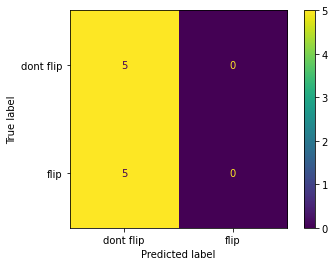

In [266]:
#confusion matrix

cm = confusion_matrix(y_test, binary_values)
#so the y_test is now giving the ANSWER KEY so the algorithm can see how it did / its performance on this test/section
#so we gave the algo/machine this test set of images, combined flip and not flip so it didn't know which was which,
#all it had was the model it was trained on w/ the training set of images and corresponding labels. that was the
#instruction/guided section. this was its turn to do it on its own/try its hand at it, no more open-book/hand-holding,
#to see how well it learned/how well it can do on its OWN! on 'un(before)seen data'!/problems
#so you see that it's actually very simple here, it's comparing the machine's answers, in 'binary_values', defined/
#assigned above, and comparing them to the CORRECT ANSWERS, as defined by us in y_test!!! confusion matrix is simply
#just a visual tool to help us see the performance w/ machine learning prediction performance

cmd = ConfusionMatrixDisplay(cm, display_labels=['dont flip','flip'])
cmd.plot()

plt.show()

In [267]:
#so of the 27 test dontflips, we correctly got 19. so 19/27 ≈ 70%
# & of the 20 test DO-FLIPS,  we correctly got 15, so 15/20 = 75%!
#okay, well, aH, at least pretty CONSISTENT!

#we can look at which ones IT GOT WRONG!!!! to see if there are any PATTERNS on something that's THROWING IT OFF!?!?
#(and also which it got RIGHT!)

In [268]:
#OHHH - WE SHOULDA TRIED TO MAKE THEM MORE *EVEN* FOR EACH MAYBE?!?! like number of flips/non-flips in both training & test to avoid RATIO/CLASS IMBALANCE/BIAS!!!!
################################################################################################################################################
#so like we SHOULDN'T have it train on numbers that reflect the actual POPULATION!?! cuz like - then it might kinda go into that mode of like when
#you see like 4 answer choice C's in a row, like no - can't be 'C' again! or if smarter, think like, ONE OF THESE must not be C!!!
#it's gotta have that / any noise like that COMPLETELY OUT OF ITS MIND!!!!!

In [269]:
#Classification Report to check metrics like Accuracy
print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



In [270]:
#yep, so, makes perfect sense - avg b/w 70 & 75 is 72/73!

#*ALSO*! in the TRAINING EPOCHS, we got a range of accuracy from .52 to .90, which *ALSO AVGS TO AROUND THE SAME*!!!! OF/@ 71.5%!!!

In [271]:
#after fixing the /255 scaling, of the 123 test images (72 flips & 51 dont flips) test images, it got almost all the
#dont flips right, but then also labeled the same number of flips as don't flip...

#after changing the image size to 32 x 32 and just cropping slightly to 28 x 28, jumped up to 63% accuracy
#it got a good chunk of the flips right, 58/72, but more than half of the DON'T flips wrong...

#okay then i decided to focus on JUST kitchens to see if that would make thing better, but again lopsided results
#took care to trim out dataset to take out potentially confusing ones, although still had mix of semi-modern and
#modern modern. but it did really well w/ the non flips, but then also said not to flip most of the flips?!
#so maybe i confused it w/ too many diff kinds of examples
#lol, this shows you how good of a teacher you are and also gives you insight into how a child's brain works...


#nice!! okay so after narrowing down types to make more consistent the model is performing much better and isn't so
#lopsided - now it's doing well over 50% for both flip & dont flip

#so next will probably be to continue to narrow/trim down to TYPES of kitchens, to get it superfocustrained on one/each
#type and also will prob need to get more images!

#hmm but then when i narrowed down further, it did even better for flips, but basically labeled EVERYTHING as a flip,
#so labeled most of the nonflips as flips

#so there could be several factors
    #there's the varying number of flip training vs. not flip training - see what they did. well actually,
    #ahmed/moustafa's experiment wasn't classification! so no categories to compare
    #there were a few images of diff starting size - maybe threw it off - but that shouldn't be cuz the first step is to MAKE EM ALL THE SAME SIZE!
    #there was that alpha/beta manipulation
    #there's stuff ahmed/moustafa did w/ the images that maybe we didn't do here, or diff versions perhaps of same type of methods, like see their CNN function compared to vs our NN
    #>>>>they do addl things like create an MLP, seems like they pretty much import the same packages from keras/tensorflow?
    #and also diff VALUES used for same things, like how we saw w/ image size, but also like epochs - they did many more

    #we might've overcomplicated the model by giving it pics of different rooms! maybe needa break it up?
    #also there were only a few / one-off (not enough) images of nonflips of exterior without much training on that
    #remem the training had alot of SEMI-modern images/examples for non-flips, and actually, some were flips,
    #so might've confused it. so could be like we suspected, may have to pick one or other
    #could be that there's other things that need to be checked, like where i altered stuff, such as taking out the axis=,etc, or like how i commented out the divide by 255!
    #check out the messages w/ the model training/epoch part?
    #there might be some differences w/ ahmed/moustafa since they were also using text. (how) did they tie both image & text
    #training & testing together? and did they have to compare each room to each room when making a prediction, like apples
    #to apples? or was that automatically figured out?
    #>>>>OHH okay i see now as i look thru ahmed/moustafa's code that they PUT EVERY SET OF 4 IMAGES TOGETHER AS A SET!
    #they make a 2x2 tile block and ensure they're in the same order / arrangement every time. so yeah may well be that we
    #have to keep it as sets, maybe of 3 cuz as we said, don't care about exterior so much; can do that separately
    #OR, can pick just ONE thing to start off w/ at first, like a kitchen, to determine if it's outdated or not

In [272]:
#remember it's not just like - if it looks like these, FLIP, if not, DON'T!
#it's if it looks like THESE OTHER ONES, DON'T FLIP!!!!
#aka, even though it's binary, YOU STILL GOTTA SHOW IT EXAMPLES OF WHAT *NOT* TO DO!!!!
#cuz like there may be other areas in between that we're NOT covering!!! we're focused on a specific RANGE!
#it's just like how WE/a KID learns!!! also needa be shown *EXAMPLES* of what *NOT* to do!!!!
########################################################################################

In [273]:
#what's the best way to see which images it identified as which, esp the wrong ones?
########################################################################################

### Conclusion

I was able to create a model with 0.__ accuracy for whether a page needs to be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the images black & white, all the same size, cropping them, adjusting brightness, adding noise, etc.

In [274]:
# Save the model using pickle

#doesn't say pickle anywhere??? lol we did import it at start/top tho

model_classifier = model.save('flip_page_classifier')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: flip_page_classifier/assets


In [275]:
#errors?^